In [1]:
import math
from inspect import isfunction
from functools import partial

# %matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

/home/reallsx/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from diffusion import *
from unet import *

from torch.utils.data import DataLoader, Dataset

In [3]:
import glob

def read_arpes_data(directory, dset_name):
    '''
    load low resolution (noisy) and high resolution arpes data from npy files.
    '''
    hr = []
    lr = []
    
    path_hr = directory + dset_name + "_hr/"
    path_lr = directory + dset_name + "_lr/"
    
    allfiles_hr = glob.glob(path_hr+"*"+".npy")
    allfiles_hr.sort()
    
    allfiles_lr = glob.glob(path_lr+"*"+".npy")
    allfiles_lr.sort()
    
    for one_file in allfiles_hr:
        hr.append(np.load(one_file)[:256,:256].reshape(1,256,256))
        # hr.append(np.load(one_file).reshape(1,300,300))
        
    for one_file in allfiles_lr:
        lr.append(np.load(one_file)[:256,:256].reshape(1,256,256))
        # lr.append(np.load(one_file).reshape(1,300,300))
        
    hr = np.stack(hr, axis = 0)
    lr = np.stack(lr, axis = 0)
    
    return hr, lr
    
    
    
    

In [4]:
train_hr, train_lr = read_arpes_data("/stor0/reallsx/arpes/", "train")

In [5]:
train_hr = train_hr * 2 - 1
train_lr = train_lr * 2 - 1

In [6]:
train_hr.shape

(1600, 1, 256, 256)

In [7]:
class apres_dataset(Dataset):
    def __init__(self, hr, lr):
        if len(hr) != len(lr):
            raise ValueError("Inputs must have the same length")
        
        self.hr = hr
        self.lr = lr

    def __len__(self):
        return len(self.hr)

    def __getitem__(self, index):
        x = torch.from_numpy(self.hr[index])
        y = torch.from_numpy(self.lr[index])
        return {'HR':x, 'SR':y}

In [8]:
train_dataset = apres_dataset(train_hr, train_lr)

In [9]:
print(torch.cuda.is_available())

print(torch.cuda.current_device())

True
0


In [10]:
from torch.nn import init

def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm2d') != -1:
        init.constant_(m.weight.data, 1.0)
        init.constant_(m.bias.data, 0.0)


In [12]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

UNET = UNet(
    in_channel=2,
    out_channel=1,
    attn_res=(8,),
    image_size=256
).to(device)



schedule_opt = {
                "schedule": "linear",
                "n_timestep": 1000,
                "linear_start": 1e-6,
                "linear_end": 1e-2
                }


diffusor = GaussianDiffusion(
        UNET,
        image_size=256,
        channels=1,
        loss_type='l2',    # L1 or L2
        conditional=True,
        schedule_opt=None
        ).to(device)

diffusor.set_new_noise_schedule(schedule_opt, device = device)
diffusor.set_loss(device = device)

# model.to(device)

UNET.apply(weights_init_orthogonal)



optimizer = Adam(UNET.parameters(), lr=3e-6)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)

In [13]:
# a small function provided by chatGPT to control GPU temperature

import time
import os

def get_gpu_temperature(gpu_id = 0):
    try:
        output = os.popen('nvidia-smi --query-gpu=temperature.gpu --format=csv').read().strip().split('\n')[1+gpu_id]
        temperature = int(output)
        return temperature
    except Exception as e:
        print(f'Error getting GPU temperature: {str(e)}')
        return None
    
def gpu_cooldown(gpu_id = 0, upper_lim = 90, lower_lim = 75, sleep_time = 30):
    temp = get_gpu_temperature(gpu_id)
    if temp < upper_lim:
        return
    else:
        while(temp > lower_lim):
            time.sleep(sleep_time)
            temp = get_gpu_temperature(gpu_id)
        return

In [50]:
optimizer = Adam(UNET.parameters(), lr=3e-6)

UNET.train()

# training_loss = []

for epoch in range(50):
    
    loss_in_epoch = []
    
    if epoch % 5 ==0:
        gpu_cooldown()
        
    for batch_idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        for key in data:
            data[key] = data[key].to(device)
        
        loss = diffusor.p_losses(data)
        loss.backward()
        optimizer.step()
        
        loss_in_epoch.append(loss.item()/5) # divide by batch size
        
        if batch_idx % 100 == 0:
            print('Epoch: {}, Batch: {}, Loss: {:.4f}'.format(epoch, batch_idx, loss.item()))
            
        
    training_loss.append(np.mean(loss_in_epoch))

Epoch: 0, Batch: 0, Loss: 4520.9668
Epoch: 0, Batch: 100, Loss: 1522.7898
Epoch: 0, Batch: 200, Loss: 2399.6411
Epoch: 0, Batch: 300, Loss: 1360.2290
Epoch: 1, Batch: 0, Loss: 1206.0962
Epoch: 1, Batch: 100, Loss: 5731.6650
Epoch: 1, Batch: 200, Loss: 7533.8271
Epoch: 1, Batch: 300, Loss: 4090.4114
Epoch: 2, Batch: 0, Loss: 2626.4473
Epoch: 2, Batch: 100, Loss: 5747.5137
Epoch: 2, Batch: 200, Loss: 1186.2804
Epoch: 2, Batch: 300, Loss: 4517.4346
Epoch: 3, Batch: 0, Loss: 2224.3745
Epoch: 3, Batch: 100, Loss: 10978.4746
Epoch: 3, Batch: 200, Loss: 3296.2046
Epoch: 3, Batch: 300, Loss: 7050.1528
Epoch: 4, Batch: 0, Loss: 1499.0437
Epoch: 4, Batch: 100, Loss: 7030.2627
Epoch: 4, Batch: 200, Loss: 6494.4268
Epoch: 4, Batch: 300, Loss: 1430.1829
Epoch: 5, Batch: 0, Loss: 6855.4727
Epoch: 5, Batch: 100, Loss: 1980.6567
Epoch: 5, Batch: 200, Loss: 7317.7539
Epoch: 5, Batch: 300, Loss: 1750.6633
Epoch: 6, Batch: 0, Loss: 5434.6333
Epoch: 6, Batch: 100, Loss: 6498.9854
Epoch: 6, Batch: 200, Los

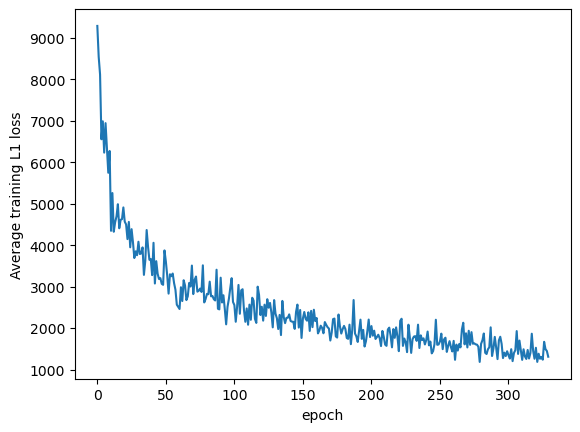

In [53]:

plt.plot(range(len(training_loss)),training_loss)
plt.xlabel("epoch")
plt.ylabel("Average training L1 loss")
plt.show()

In [54]:
UNET.eval()
sample = diffusor.super_resolution(torch.tensor(train_lr[-1].reshape(1,1,256,256)).to(device))

sampling loop time step: 100%|███████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.85it/s]


In [56]:
sample_np = sample.cpu().numpy()

In [160]:
sample_np.shape

(1, 256, 256)

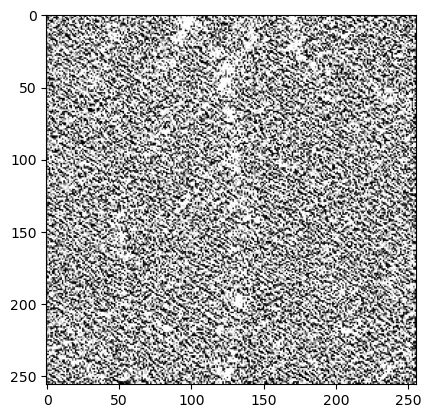

In [161]:
plt.imshow(sample_np.reshape((256,256)), cmap='gray')

In [40]:
def remove_ticks():
    plt.xticks([])
    plt.yticks([])

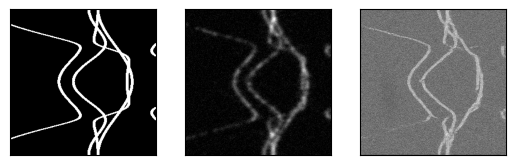

In [34]:
plt.subplot(131)
plt.imshow(train_hr[0].reshape(256,256),cmap='gray', vmin=-1, vmax=1)
remove_ticks()
plt.subplot(132)
plt.imshow(train_lr[0].reshape(256,256),cmap='gray', vmin=-1, vmax=1)
remove_ticks()
plt.subplot(133)
plt.imshow(sample_np.reshape((256,256)), cmap='gray', vmin=-1, vmax=1)
remove_ticks()

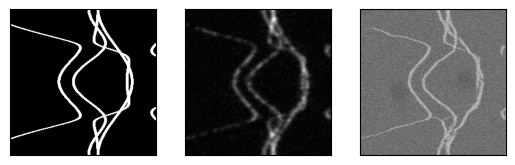

In [41]:
plt.subplot(131)
plt.imshow(train_hr[0].reshape(256,256),cmap='gray', vmin=-1, vmax=1)
remove_ticks()
plt.subplot(132)
plt.imshow(train_lr[0].reshape(256,256),cmap='gray', vmin=-1, vmax=1)
remove_ticks()
plt.subplot(133)
plt.imshow(sample_np.reshape((256,256)), cmap='gray', vmin=-1, vmax=1)
remove_ticks()

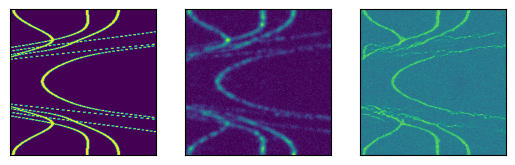

In [49]:
plt.subplot(131)
plt.imshow(train_hr[-1].reshape(256,256), vmin=-1, vmax=1)
remove_ticks()
plt.subplot(132)
plt.imshow(train_lr[-1].reshape(256,256), vmin=-1, vmax=1)
remove_ticks()
plt.subplot(133)
plt.imshow(sample_np.reshape((256,256)), vmin=-1, vmax=1)
remove_ticks()

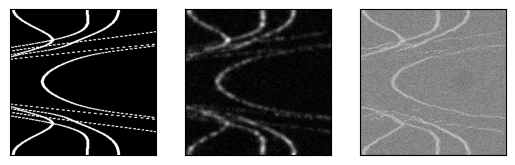

In [57]:
plt.subplot(131)
plt.imshow(train_hr[-1].reshape(256,256),cmap='gray', vmin=-1, vmax=1)
remove_ticks()
plt.subplot(132)
plt.imshow(train_lr[-1].reshape(256,256),cmap='gray', vmin=-1, vmax=1)
remove_ticks()
plt.subplot(133)
plt.imshow(sample_np.reshape((256,256)), cmap='gray', vmin=-1, vmax=1)
remove_ticks()

In [ ]:
UNET_PATH = "./unet.pt"